In [1]:
import pandas as pd
import pickle
from scripts.interactive_search import *
import numpy as np
import networkx as nx
from networkx.algorithms import community
from networkx.readwrite import json_graph
import colorsys
import matplotlib.pyplot as plt
from skimage import io
import json
import math
import time
from scipy.spatial.distance import cdist, pdist
import random

In [2]:
# Change this function to select a different paper set
def read_metadata(path):
    df = pd.read_csv(path)
    df = df.astype({'abstract': 'str'})
    df = df[df['abstract'] != 'Unknown']
    df = df[df['abstract'] != 'nan']
    df = df[df['language'] == 'en']
    #df = df[df['publish_time'].str[:4] == '2020']
    df = df.reset_index(drop=True)
    #df = df[:1000]
    return df

In [3]:
load_from_pickle = True
#EMBEDDINGS_PATH = 'data/embeddings_top5k.pkl'
#EMBEDDINGS_PATH = 'data/embeddings_2020.pkl'
#EMBEDDINGS_PATH = 'data/embeddings_2020_top1k.pkl'
#EMBEDDINGS_PATH = 'data/embeddings_sharp_top1k.pkl'
EMBEDDINGS_PAHT = 'data/embeddings_subtopics_sharp_all.pkl'
#METADATA_PATH = 'data/metadata_new_new.csv'
#METADATA_PATH = 'data/metadata_sharp.csv'
METADATA_PATH = 'data/metadata_subtopics_sharp.csv'

df_meta = read_metadata(METADATA_PATH)
abstracts = [a for a in df_meta['abstract']]
titles = df_meta['title'].reset_index(drop=True)

if load_from_pickle:
    with open(EMBEDDINGS_PATH, 'rb') as file:
        embeddings = pickle.load(file)

else:
    model = SentenceTransformer(MODEL_PATH)
    embeddings = model.encode(abstracts, show_progress_bar=True)
    with open(EMBEDDINGS_PATH, 'wb') as file:
        pickle.dump(embeddings, file)
        
embeddings_array = np.array(embeddings)

In [4]:
n_topics = 8
n_subtopics = 8
df_meta_splits = []
titles_splits = []
abstracts_splits = []
embeddings_splits = []

for i in range(n_topics):
    df_meta_splits.append([])
    titles_splits.append([])
    abstracts_splits.append([])
    embeddings_splits.append([])
    
    topic = df_meta[df_meta['main_topic'] == i]
    for j in range(n_subtopics):
        subtopic = topic[topic['main_subtopic'] == j]
        df_meta_splits[i].append(subtopic)
        abstracts_splits[i].append([a for a in df_meta_splits[i][j]['abstract']])
        titles_splits[i].append(df_meta_splits[i][j]['title'].reset_index(drop=True))
        embeddings_splits[i].append(embeddings_array[list(df_meta_splits[i][j].index)])

In [5]:
def compute_adjacency(embeddings, epsilon):
    cosine_distances = scipy.spatial.distance.cdist(embeddings, embeddings, "cosine")
    cosine_similarities = 1 - cosine_distances
    cosine_similarities[cosine_similarities < epsilon] = 0
    np.fill_diagonal(cosine_similarities, 0.0)
    return cosine_similarities

In [6]:
def unordered_connected_components(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
def connected_components(G):
    return sorted(list(unordered_connected_components(G)), key=len, reverse=True)

In [7]:
def compute_clusters_fluid(G, n_clusters=10, dtype='title'):
    clusters = []
    iterator = community.asyn_fluidc(G, n_clusters, max_iter=1)
    for cluster in iterator:
        clusters.append(cluster)

    return clusters

In [8]:
# Todo: parallelize

def fruchterman(G, area=10000.0, gravity=10.0, speed_init=10.0, iterations=10):
    AREA_MULTIPLICATOR = 10000
    speed_reduction_steps = 4
    SPEED_DIVISOR = 800
    
    nodes = G.nodes
    edges = G.edges(data=True)
    
    layout = area * 2 * np.random.random_sample((len(G.nodes), 2)) - area

    max_displace = (float) (math.sqrt(AREA_MULTIPLICATOR * area) / 10.0)
    k = float (math.sqrt((AREA_MULTIPLICATOR * area) / (1.0 + len(nodes))))
    force = 0
    start = time.time()
    for i in range(iterations):
        speed = speed_init * 10 ** (- (i+1) // (iterations / speed_reduction_steps) + 1)
        forces = np.zeros((len(G.nodes), 2))
        iteration_start = time.time()
        elapsed_time = iteration_start - start
        print("Iteration " + repr(i+1) + "/" + repr(iterations) + " - Elapsed time: " + "{0:0.2f}".format(elapsed_time) + "s - Force: {0:.0f}".format(force) + " - Speed: " + repr(speed), end='\r')

        layout_x = layout[:, 0]
        layout_y = layout[:, 1]
        x_distances = np.subtract.outer(layout_x, layout_x)
        y_distances = np.subtract.outer(layout_y, layout_y)
        distances = cdist(layout, layout)
        divs = distances ** 2 / k ** 2
        force_x = x_distances / divs
        force_y = y_distances / divs
        forces[:, 0] += np.nansum(force_x, axis=1)
        forces[:, 1] += np.nansum(force_y, axis=1)

        for e in edges:
            n1 = e[0]
            n2 = e[1]
            x_dist = layout[n1][0] - layout[n2][0]
            y_dist = layout[n1][1] - layout[n2][1]
            dist = float (math.sqrt(x_dist ** 2 + y_dist ** 2))
            attractive_f = dist * dist / k
            if dist > 0:
                forces[n1][0] -= x_dist / dist * attractive_f
                forces[n1][1] -= y_dist / dist * attractive_f
                forces[n2][0] += x_dist / dist * attractive_f
                forces[n2][1] += y_dist / dist * attractive_f

        for n in nodes:
            d = float (math.sqrt(layout[n][0] ** 2 + layout[n][1] ** 2))  # Todo: remove d (unused)
            gf = 0.01 * k * gravity
            forces[n][0] -= gf * layout[n][0]
            forces[n][1] -= gf * layout[n][1]
        
        for n in nodes:
            x_dist = forces[n][0] * speed / SPEED_DIVISOR
            y_dist = forces[n][1] * speed / SPEED_DIVISOR
            dist = float (math.sqrt(x_dist ** 2 + y_dist ** 2))
            if dist > 0:
                limited_dist = min(max_displace * (speed / SPEED_DIVISOR), dist)
                layout[n][0] += x_dist / dist * limited_dist
                layout[n][1] += y_dist / dist * limited_dist
                
        force = abs(forces).sum()
    
    dict_layout = {}
    for node in G.nodes:
        dict_layout.update({index_to_title[node]: layout[node]})

    print("\nComplete! - Elapsed time: " + "{0:0.2f}".format(elapsed_time) + "s")
    return dict_layout

In [9]:
def rgb(color_string):
    values = color_string[4:-1].split(",")
    r = int(values[0])
    g = int(values[1])
    b = int(values[2])
    return r, g, b

In [10]:
def rgb_string(r, g, b):
    return 'rgb(' + repr(r) + ',' + repr(g) + ',' + repr(b) + ')'

In [11]:
def merge_colors(c1, c2):
    r1, g1, b1 = rgb(c1)
    r2, g2, b2 = rgb(c2)
    
    r = int((r1+r2)/2)
    g = int((g1+g2)/2)
    b = int((b1+b2)/2)
    return r, g, b

In [12]:
def compute_palette(s=0.9, v=1.0, n_clusters=3, shift=0.0, plot=True):
    cluster_to_color = {}
    for i in range(n_clusters):
        h = (i * (1.0 / n_clusters) + shift) % 1.0
        color = colorsys.hsv_to_rgb(h, s, v)
        cluster_to_color.update({i: rgb_string(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))})

    cluster_to_color.update({-1: 'rgb(128,128,128)'})  # Grey for nodes without a cluster
    
    if plot:
        palette = np.zeros((1, n_clusters+1, 3), dtype=np.uint8)
        for i in range(-1, n_clusters):
            string = cluster_to_color[i]
            r, g, b = rgb(string)
            palette[0, i+1] = np.array([r, g, b])

        io.imshow(palette)
        plt.axis('off')
        plt.show()
        
    return cluster_to_color

Graph 0.0 - Elapsed time: 0.00s
Number of nodes: 591 - Non-zero weight percentage: 1.52%
Iteration 1000/1000 - Elapsed time: 39.11s - Force: 58225 - Speed: 0.20000
Complete! - Elapsed time: 39.11s


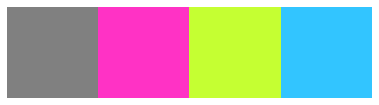

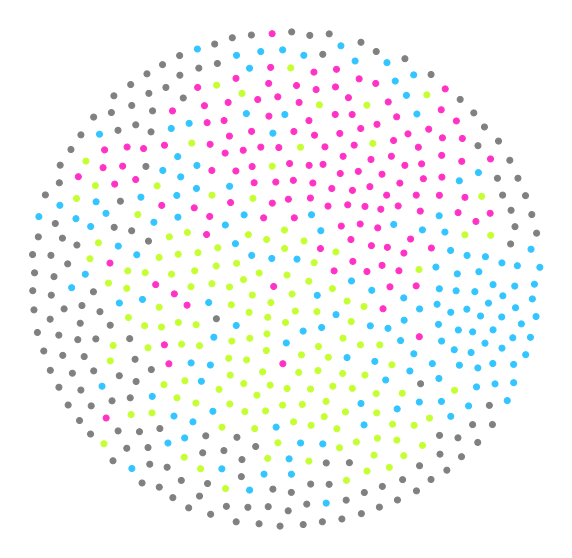

Graph 0.1 - Elapsed time: 40.65s
Number of nodes: 525 - Non-zero weight percentage: 4.18%
Iteration 1000/1000 - Elapsed time: 65.84s - Force: 54623 - Speed: 0.20000
Complete! - Elapsed time: 65.84s


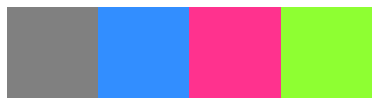

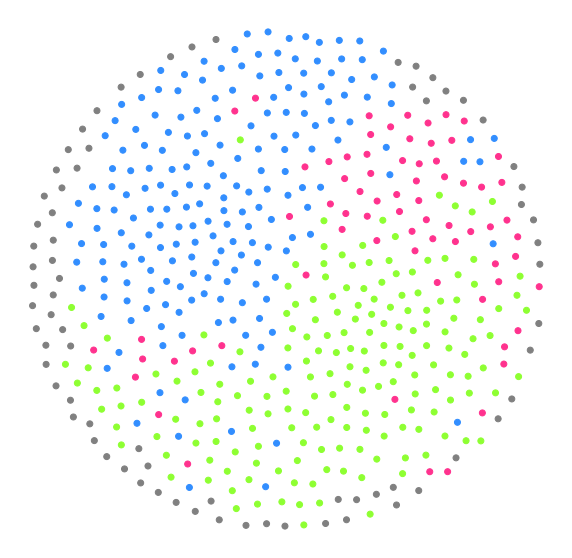

Graph 0.2 - Elapsed time: 108.37s
Number of nodes: 749 - Non-zero weight percentage: 1.45%
Iteration 1000/1000 - Elapsed time: 72.57s - Force: 69689 - Speed: 0.20000
Complete! - Elapsed time: 72.57s


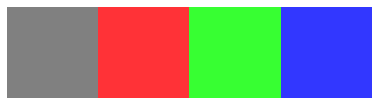

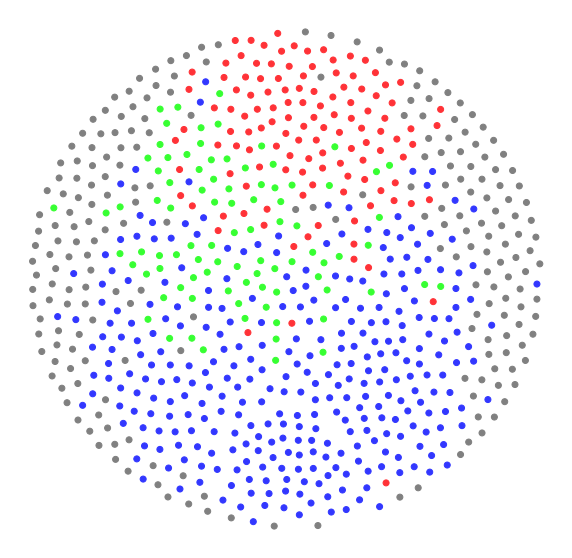

Graph 0.3 - Elapsed time: 184.74s
Number of nodes: 643 - Non-zero weight percentage: 7.82%
Iteration 1000/1000 - Elapsed time: 171.49s - Force: 23170 - Speed: 0.2000
Complete! - Elapsed time: 171.49s


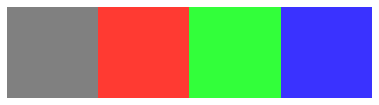

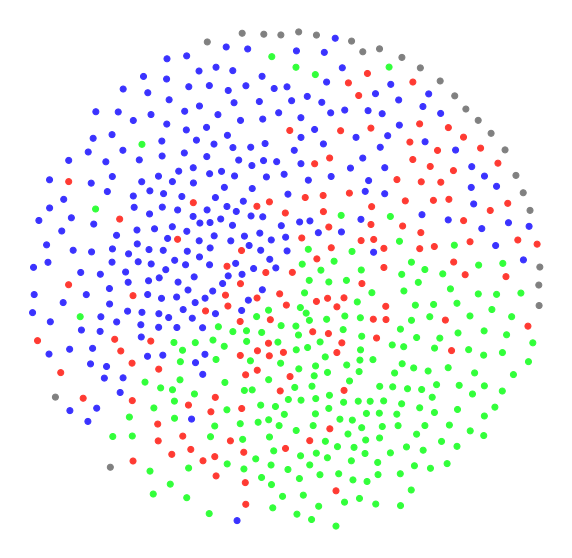

Graph 0.4 - Elapsed time: 359.38s
Number of nodes: 917 - Non-zero weight percentage: 5.96%
Iteration 1000/1000 - Elapsed time: 337.67s - Force: 58613 - Speed: 0.20000
Complete! - Elapsed time: 337.67s


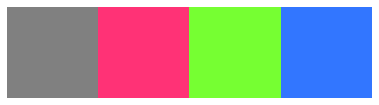

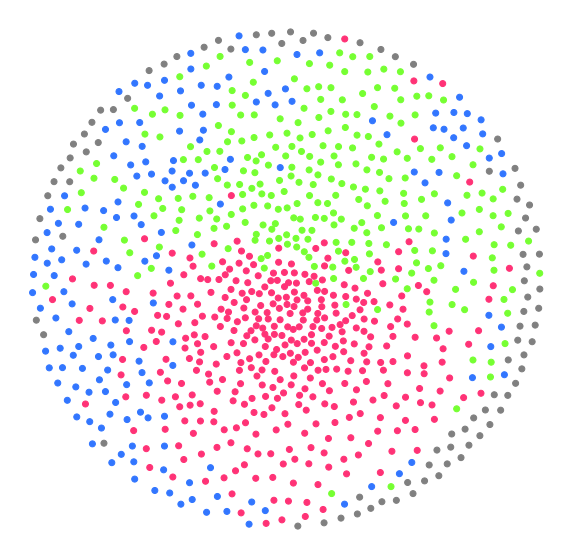

Graph 0.5 - Elapsed time: 706.54s
Number of nodes: 631 - Non-zero weight percentage: 7.15%
Iteration 1000/1000 - Elapsed time: 182.38s - Force: 32106 - Speed: 0.2000
Complete! - Elapsed time: 182.38s


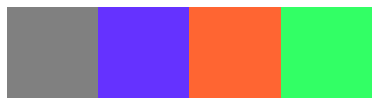

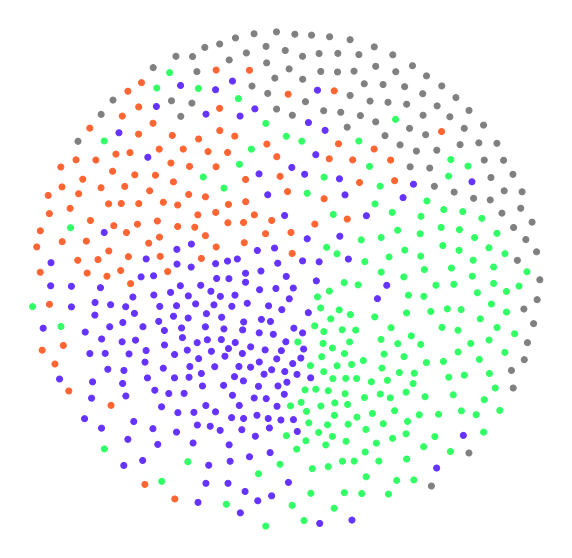

Graph 0.6 - Elapsed time: 895.47s
Number of nodes: 632 - Non-zero weight percentage: 3.43%
Iteration 1000/1000 - Elapsed time: 113.26s - Force: 85088 - Speed: 0.2000
Complete! - Elapsed time: 113.26s


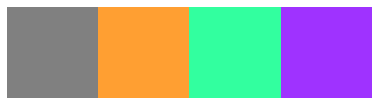

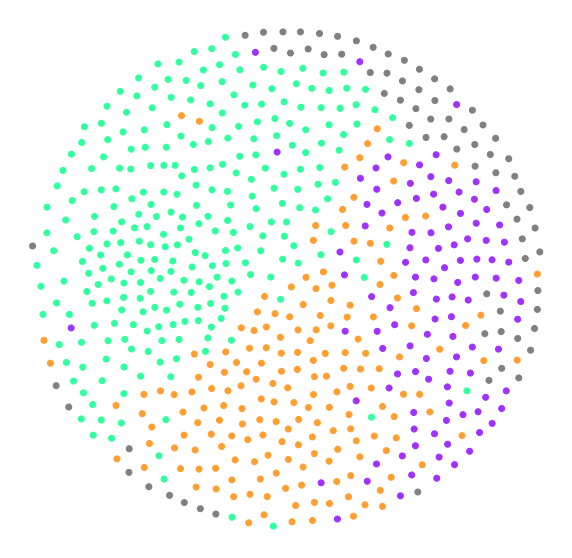

Graph 0.7 - Elapsed time: 1013.79s
Number of nodes: 567 - Non-zero weight percentage: 1.58%
Iteration 1000/1000 - Elapsed time: 66.22s - Force: 77811 - Speed: 0.20000
Complete! - Elapsed time: 66.22s


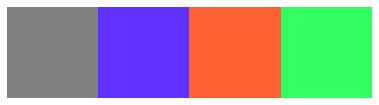

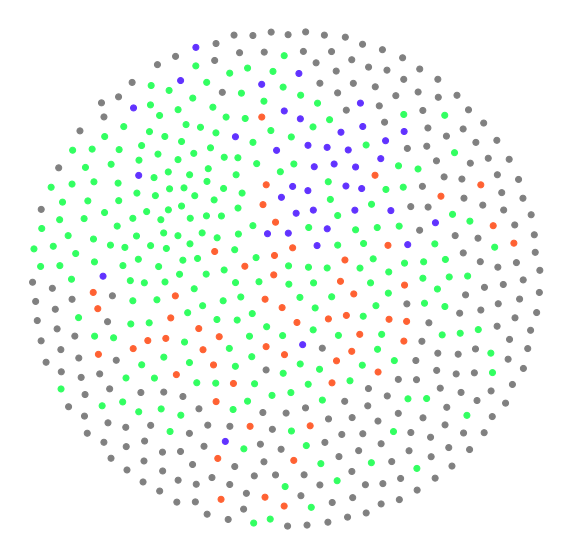

Graph 1.0 - Elapsed time: 1083.34s
Number of nodes: 460 - Non-zero weight percentage: 9.87%
Iteration 1000/1000 - Elapsed time: 120.50s - Force: 32939 - Speed: 0.2000
Complete! - Elapsed time: 120.50s


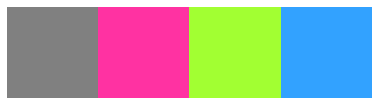

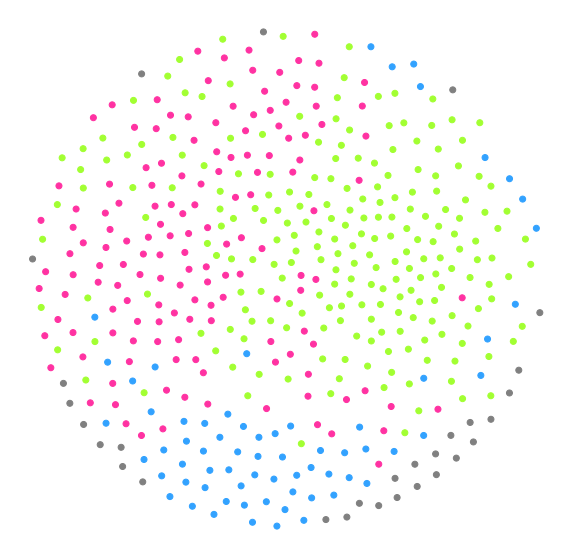

Graph 1.1 - Elapsed time: 1206.55s
Number of nodes: 281 - Non-zero weight percentage: 5.25%
Iteration 1000/1000 - Elapsed time: 25.87s - Force: 46291 - Speed: 0.2000
Complete! - Elapsed time: 25.87s


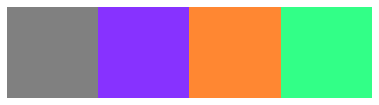

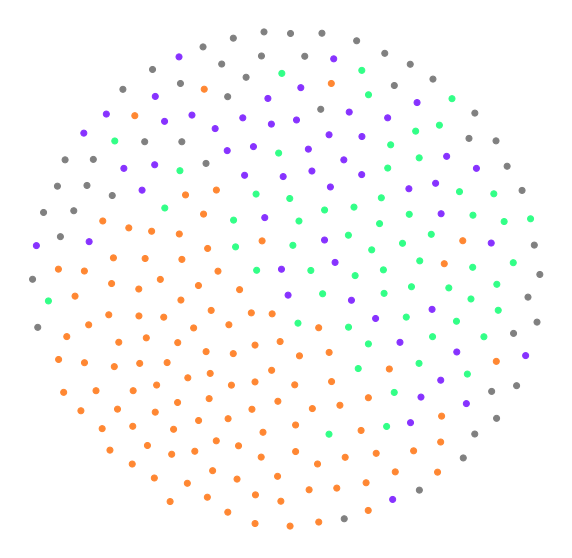

Graph 1.2 - Elapsed time: 1233.21s
Number of nodes: 187 - Non-zero weight percentage: 1.90%
Iteration 1000/1000 - Elapsed time: 8.09s - Force: 37622 - Speed: 0.20000
Complete! - Elapsed time: 8.09s


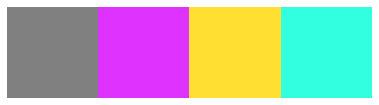

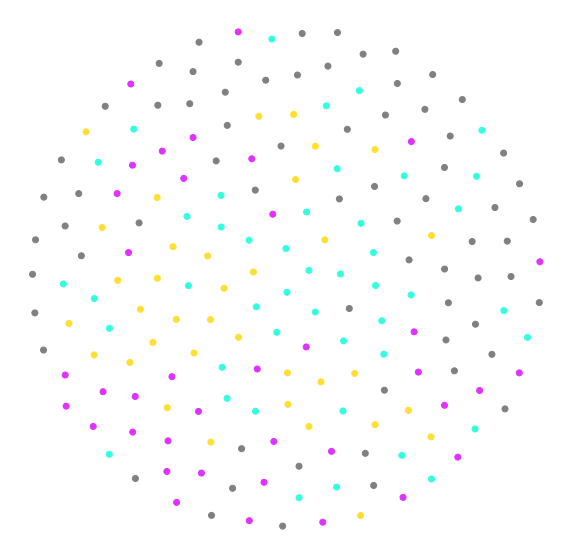

Graph 1.3 - Elapsed time: 1241.79s
Number of nodes: 374 - Non-zero weight percentage: 21.10%
Iteration 1000/1000 - Elapsed time: 182.09s - Force: 40179 - Speed: 0.2000
Complete! - Elapsed time: 182.09s


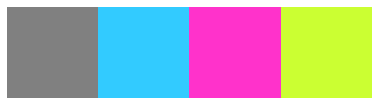

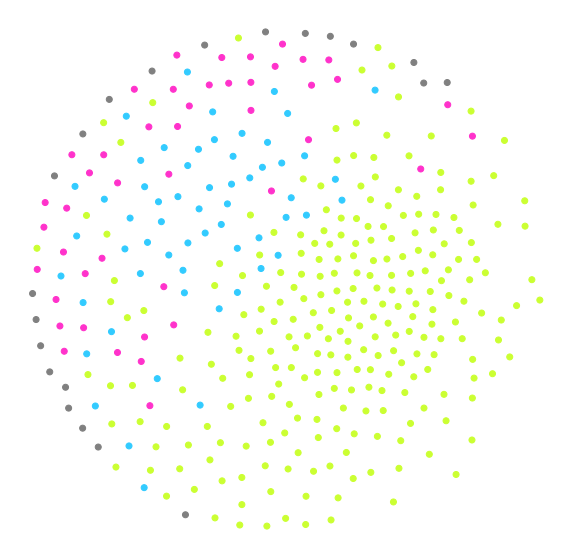

Graph 1.4 - Elapsed time: 1429.26s
Number of nodes: 319 - Non-zero weight percentage: 1.06%
Iteration 1000/1000 - Elapsed time: 21.58s - Force: 39923 - Speed: 0.2000
Complete! - Elapsed time: 21.58s


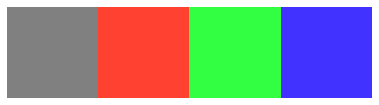

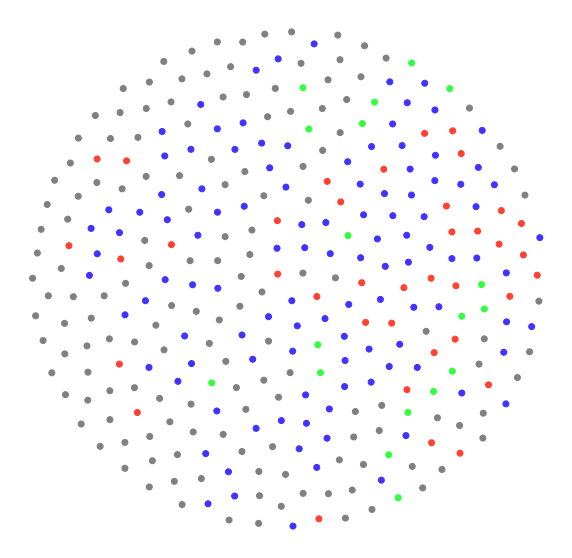

Graph 1.5 - Elapsed time: 1452.04s
Number of nodes: 380 - Non-zero weight percentage: 2.92%
Iteration 1000/1000 - Elapsed time: 30.25s - Force: 50538 - Speed: 0.2000
Complete! - Elapsed time: 30.25s


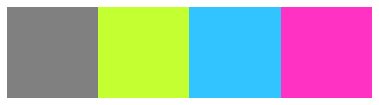

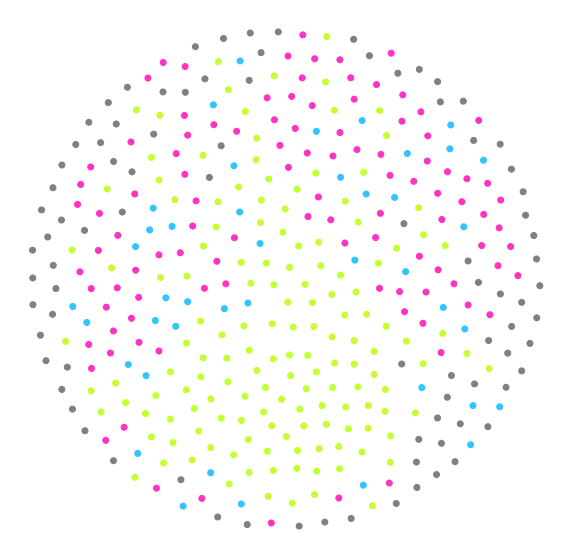

Graph 1.6 - Elapsed time: 1483.31s
Number of nodes: 350 - Non-zero weight percentage: 4.95%
Iteration 1000/1000 - Elapsed time: 37.23s - Force: 66919 - Speed: 0.20000
Complete! - Elapsed time: 37.23s


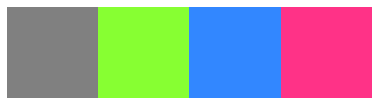

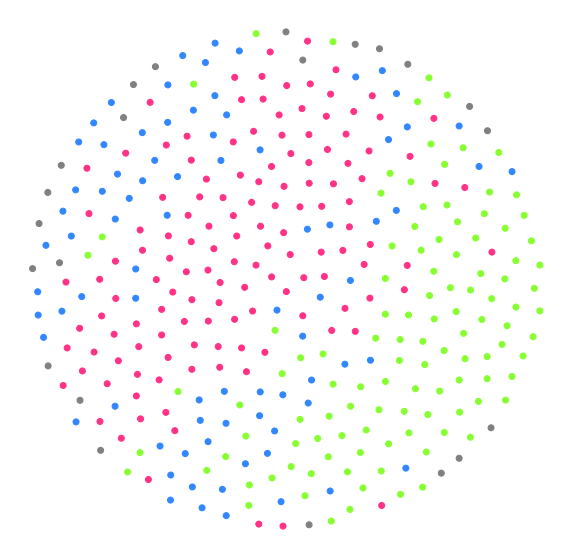

Graph 1.7 - Elapsed time: 1521.40s
Number of nodes: 727 - Non-zero weight percentage: 4.34%
Iteration 1000/1000 - Elapsed time: 158.22s - Force: 49733 - Speed: 0.2000
Complete! - Elapsed time: 158.22s


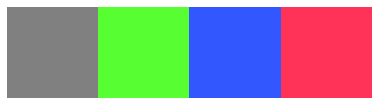

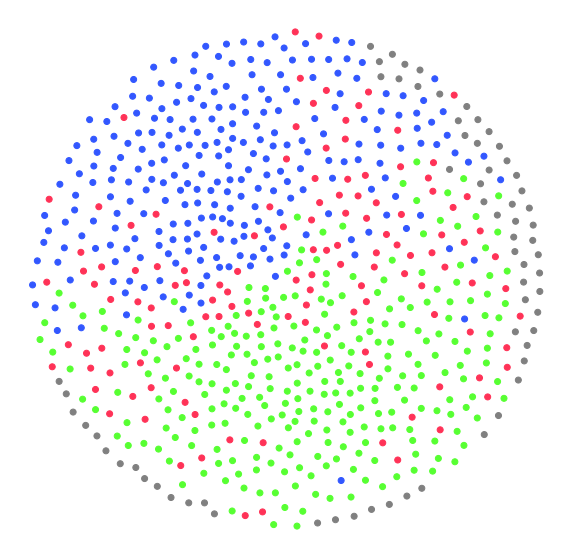

Graph 2.0 - Elapsed time: 1683.97s
Number of nodes: 801 - Non-zero weight percentage: 3.17%
Iteration 1000/1000 - Elapsed time: 198.41s - Force: 68811 - Speed: 0.2000
Complete! - Elapsed time: 198.41s


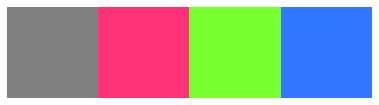

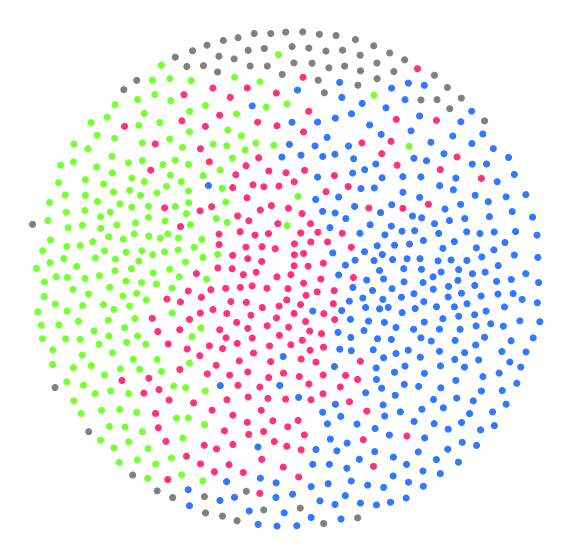

Graph 2.1 - Elapsed time: 1886.67s
Number of nodes: 978 - Non-zero weight percentage: 6.26%
Iteration 1000/1000 - Elapsed time: 363.11s - Force: 44708 - Speed: 0.20000
Complete! - Elapsed time: 363.11s


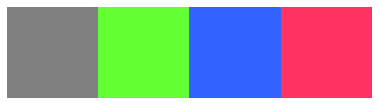

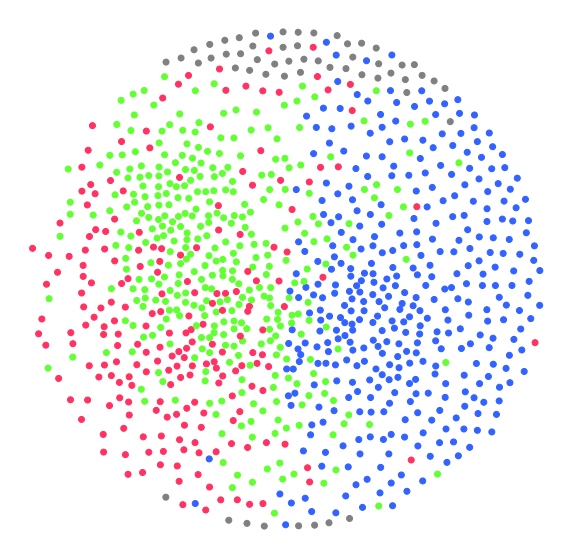

Graph 2.2 - Elapsed time: 2258.06s
Number of nodes: 819 - Non-zero weight percentage: 3.94%
Iteration 1000/1000 - Elapsed time: 186.03s - Force: 76912 - Speed: 0.2000
Complete! - Elapsed time: 186.03s


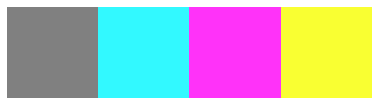

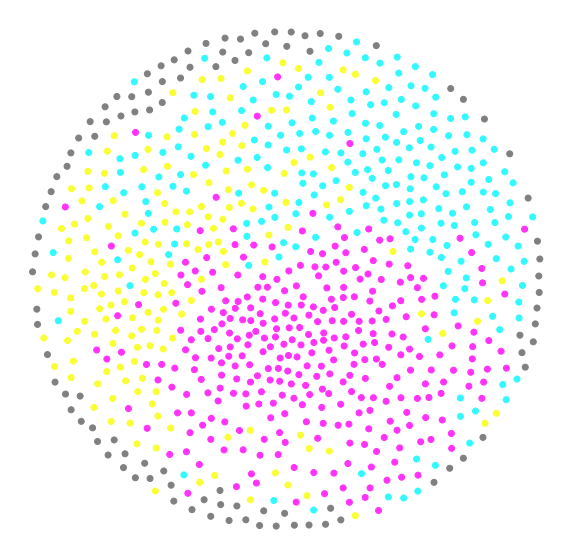

Graph 2.3 - Elapsed time: 2449.77s
Number of nodes: 1061 - Non-zero weight percentage: 3.04%
Iteration 1000/1000 - Elapsed time: 226.22s - Force: 56604 - Speed: 0.2000
Complete! - Elapsed time: 226.22s


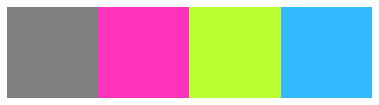

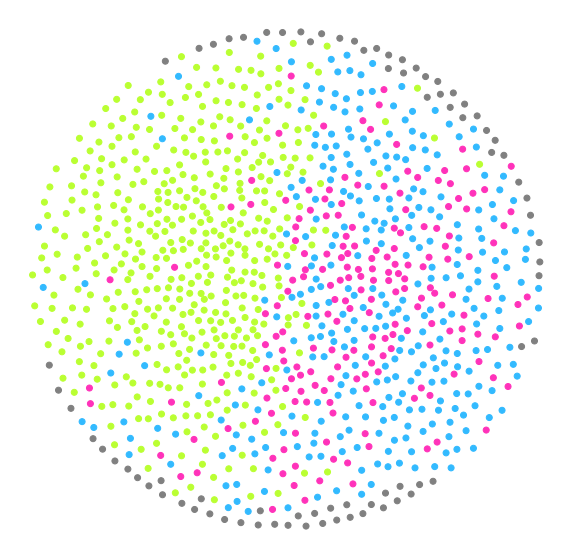

Graph 2.4 - Elapsed time: 2683.40s
Number of nodes: 553 - Non-zero weight percentage: 3.56%
Iteration 1000/1000 - Elapsed time: 56.38s - Force: 49597 - Speed: 0.20000
Complete! - Elapsed time: 56.38s


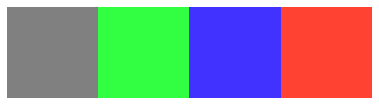

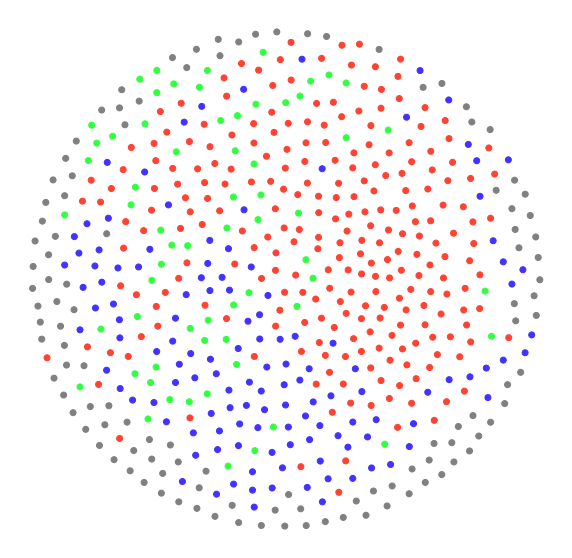

Graph 2.5 - Elapsed time: 2741.74s
Number of nodes: 861 - Non-zero weight percentage: 1.21%
Iteration 1000/1000 - Elapsed time: 73.92s - Force: 79215 - Speed: 0.20000
Complete! - Elapsed time: 73.92s


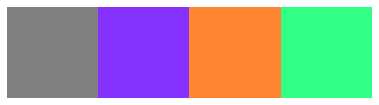

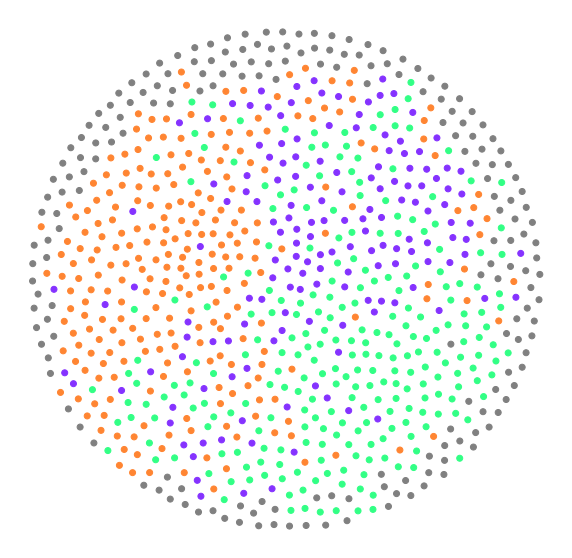

Graph 2.6 - Elapsed time: 2818.38s
Number of nodes: 575 - Non-zero weight percentage: 6.33%
Iteration 1000/1000 - Elapsed time: 92.41s - Force: 76928 - Speed: 0.20000
Complete! - Elapsed time: 92.41s


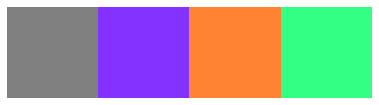

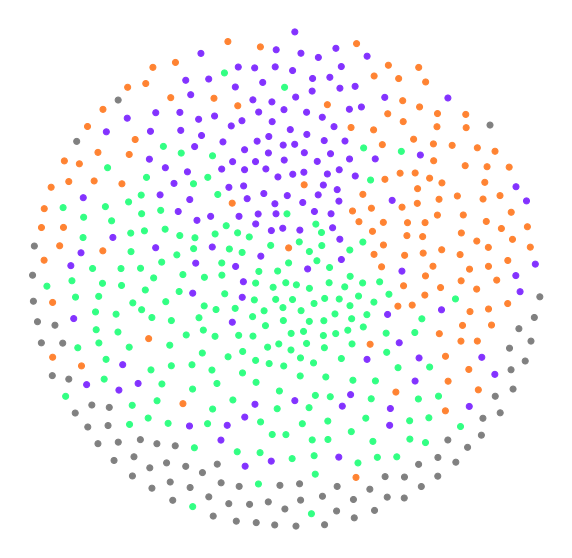

Graph 2.7 - Elapsed time: 2913.57s
Number of nodes: 699 - Non-zero weight percentage: 8.43%
Iteration 1000/1000 - Elapsed time: 166.89s - Force: 29156 - Speed: 0.2000
Complete! - Elapsed time: 166.89s


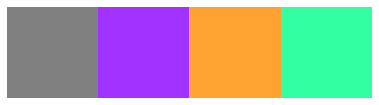

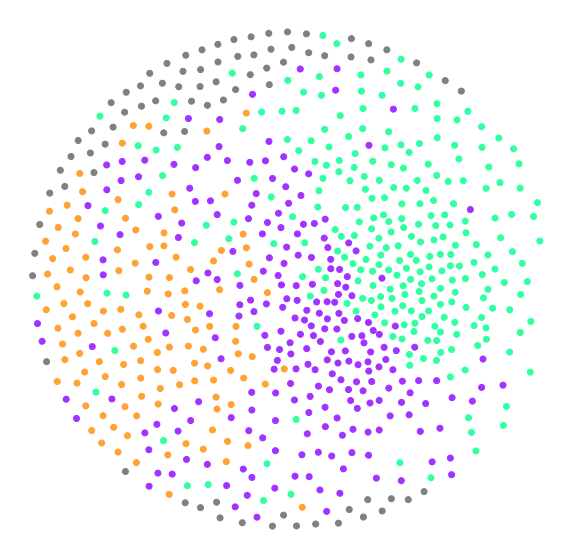

Graph 3.0 - Elapsed time: 3085.24s
Number of nodes: 364 - Non-zero weight percentage: 9.23%
Iteration 1000/1000 - Elapsed time: 50.09s - Force: 37326 - Speed: 0.20000
Complete! - Elapsed time: 50.09s


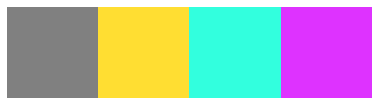

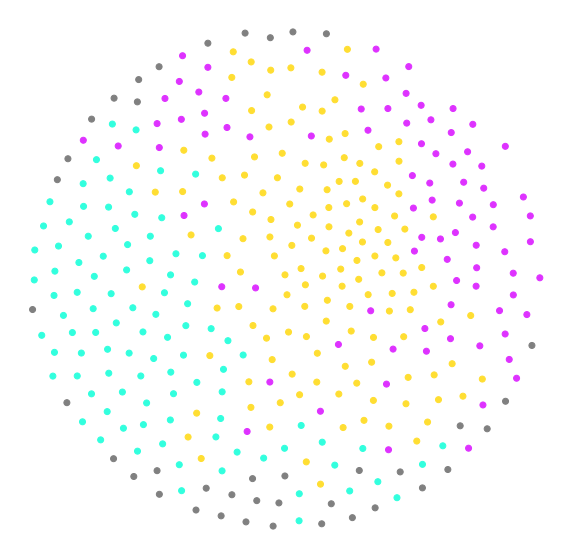

Graph 3.1 - Elapsed time: 3136.50s
Number of nodes: 339 - Non-zero weight percentage: 16.37%
Iteration 1000/1000 - Elapsed time: 67.83s - Force: 69438 - Speed: 0.20000
Complete! - Elapsed time: 67.83s


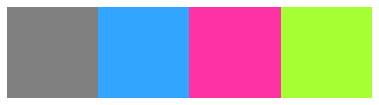

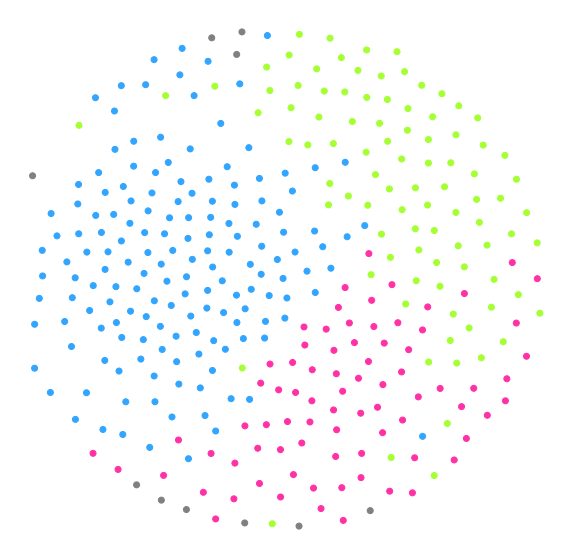

Graph 3.2 - Elapsed time: 3205.41s
Number of nodes: 179 - Non-zero weight percentage: 9.49%
Iteration 1000/1000 - Elapsed time: 12.36s - Force: 43194 - Speed: 0.2000
Complete! - Elapsed time: 12.36s


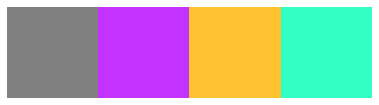

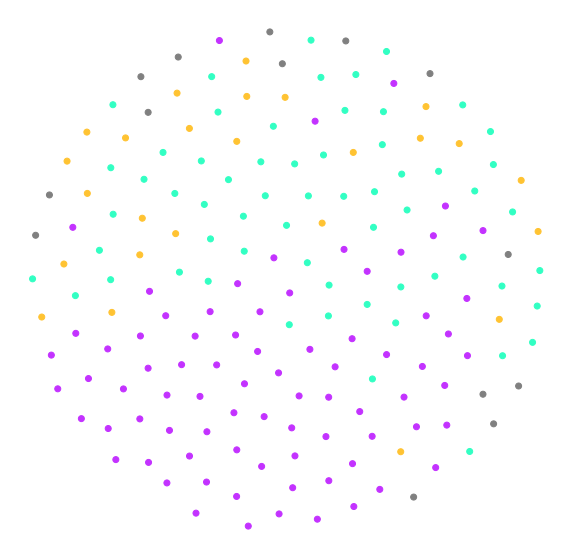

Graph 3.3 - Elapsed time: 3218.10s
Number of nodes: 459 - Non-zero weight percentage: 21.08%
Iteration 1000/1000 - Elapsed time: 157.97s - Force: 108751 - Speed: 0.200
Complete! - Elapsed time: 157.97s


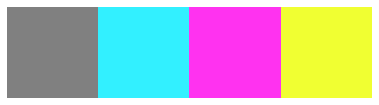

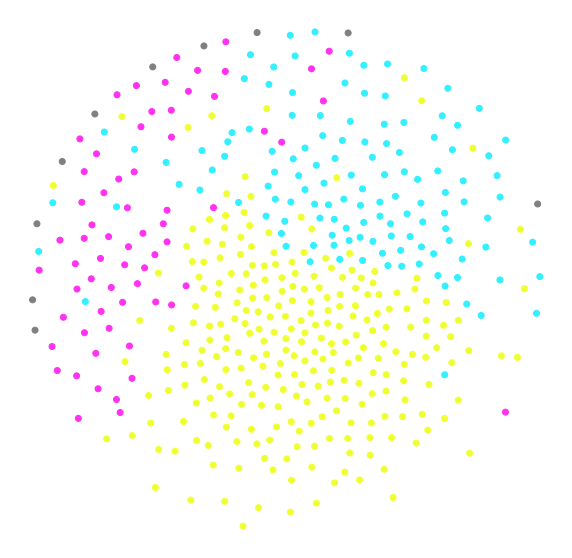

Graph 3.4 - Elapsed time: 3378.45s
Number of nodes: 191 - Non-zero weight percentage: 21.62%
Iteration 1000/1000 - Elapsed time: 27.76s - Force: 22458 - Speed: 0.20000
Complete! - Elapsed time: 27.76s


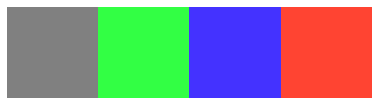

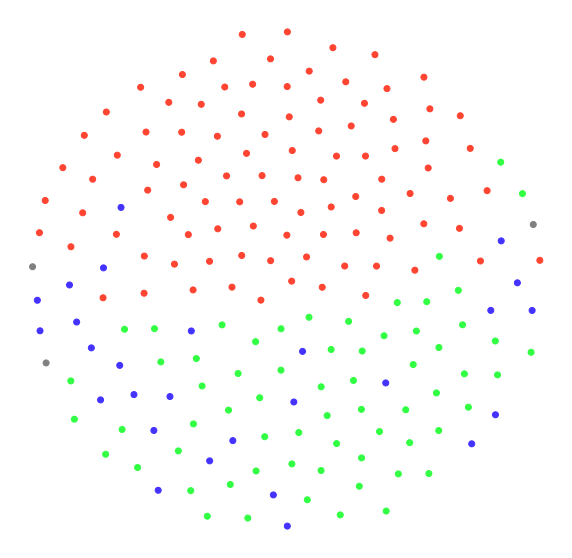

Graph 3.5 - Elapsed time: 3406.70s
Number of nodes: 401 - Non-zero weight percentage: 21.32%
Iteration 1000/1000 - Elapsed time: 120.84s - Force: 37532 - Speed: 0.2000
Complete! - Elapsed time: 120.84s


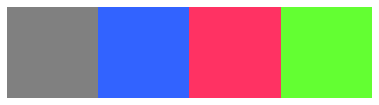

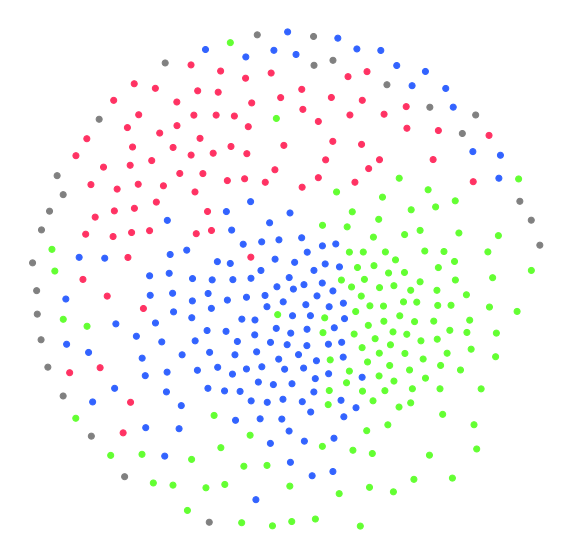

Graph 3.6 - Elapsed time: 3529.54s
Number of nodes: 744 - Non-zero weight percentage: 17.22%
Iteration 1000/1000 - Elapsed time: 347.50s - Force: 41516 - Speed: 0.20000
Complete! - Elapsed time: 347.50s


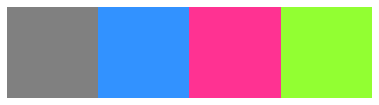

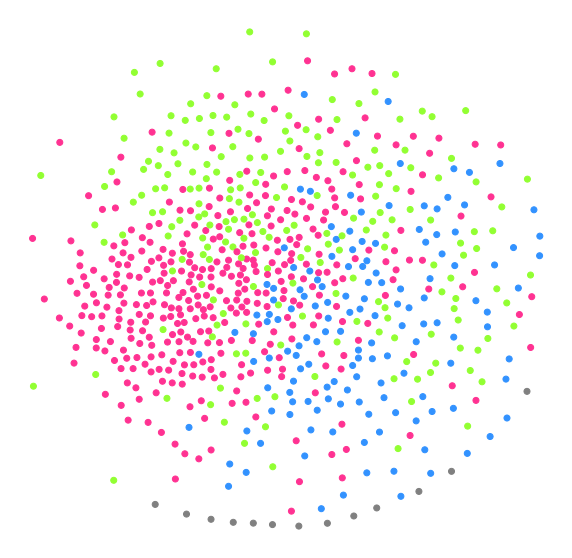

Graph 3.7 - Elapsed time: 3882.08s
Number of nodes: 712 - Non-zero weight percentage: 17.12%
Iteration 1000/1000 - Elapsed time: 306.21s - Force: 89908 - Speed: 0.20000
Complete! - Elapsed time: 306.21s


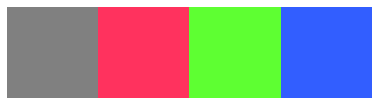

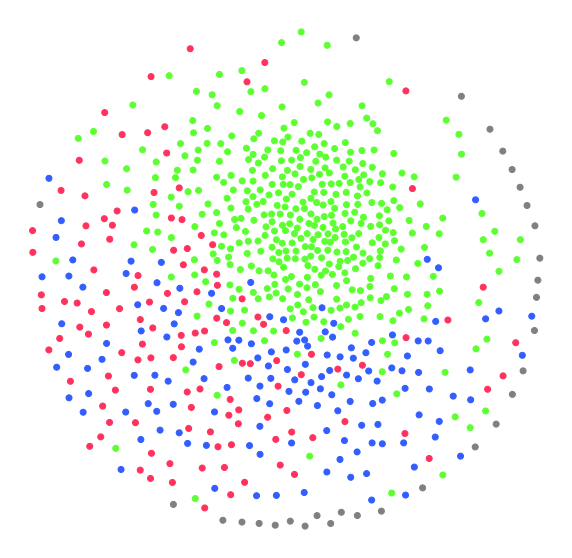

Graph 4.0 - Elapsed time: 4193.92s
Number of nodes: 489 - Non-zero weight percentage: 8.37%
Iteration 1000/1000 - Elapsed time: 82.42s - Force: 41674 - Speed: 0.20000
Complete! - Elapsed time: 82.42s


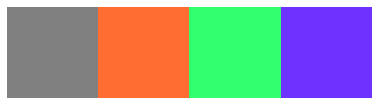

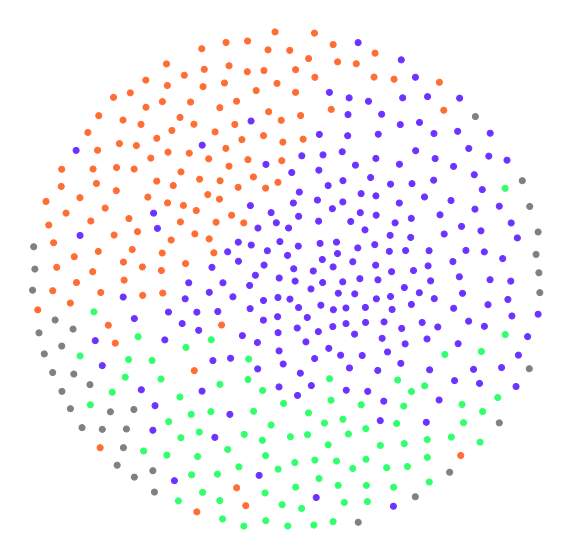

Graph 4.1 - Elapsed time: 4277.99s
Number of nodes: 561 - Non-zero weight percentage: 17.02%
Iteration 1000/1000 - Elapsed time: 188.30s - Force: 15830 - Speed: 0.20000
Complete! - Elapsed time: 188.30s


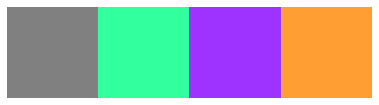

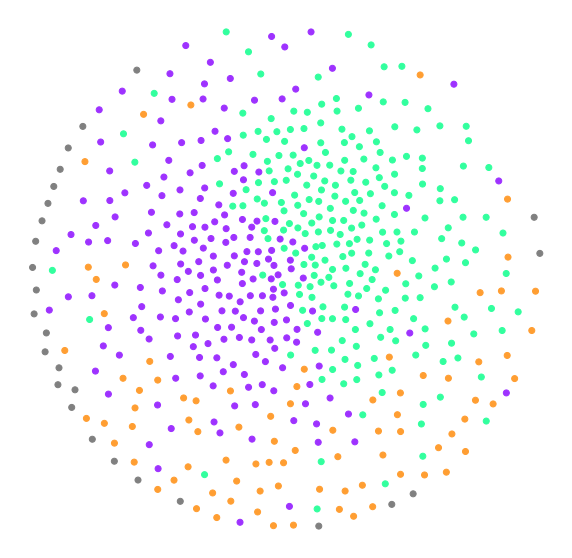

Graph 4.2 - Elapsed time: 4469.82s
Number of nodes: 421 - Non-zero weight percentage: 5.97%
Iteration 1000/1000 - Elapsed time: 45.78s - Force: 47833 - Speed: 0.20000
Complete! - Elapsed time: 45.78s


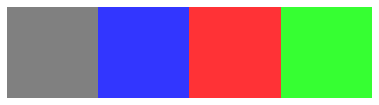

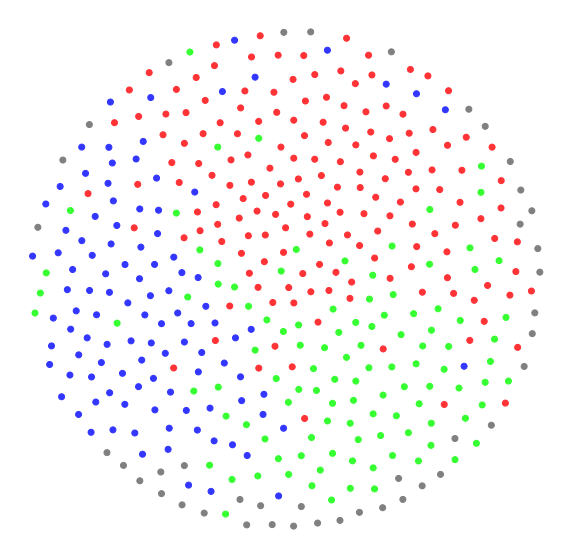

Graph 4.3 - Elapsed time: 4516.65s
Number of nodes: 343 - Non-zero weight percentage: 9.85%
Iteration 1000/1000 - Elapsed time: 43.90s - Force: 28840 - Speed: 0.20000
Complete! - Elapsed time: 43.90s


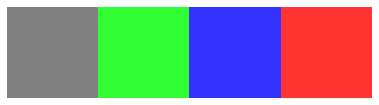

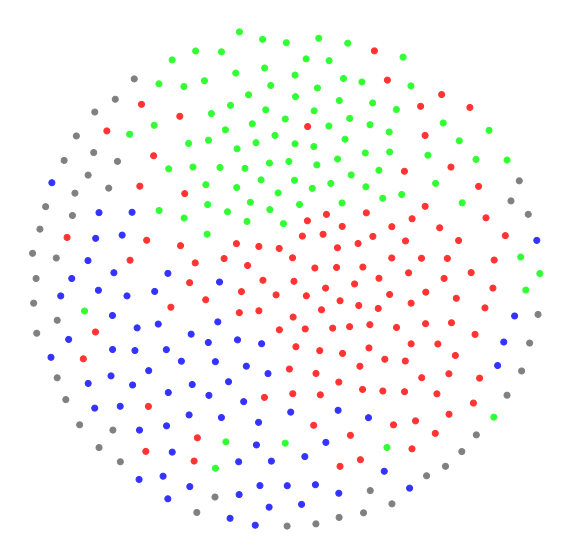

Graph 4.4 - Elapsed time: 4561.76s
Number of nodes: 745 - Non-zero weight percentage: 13.32%
Iteration 1000/1000 - Elapsed time: 269.12s - Force: 76202 - Speed: 0.20000
Complete! - Elapsed time: 269.12s


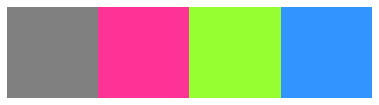

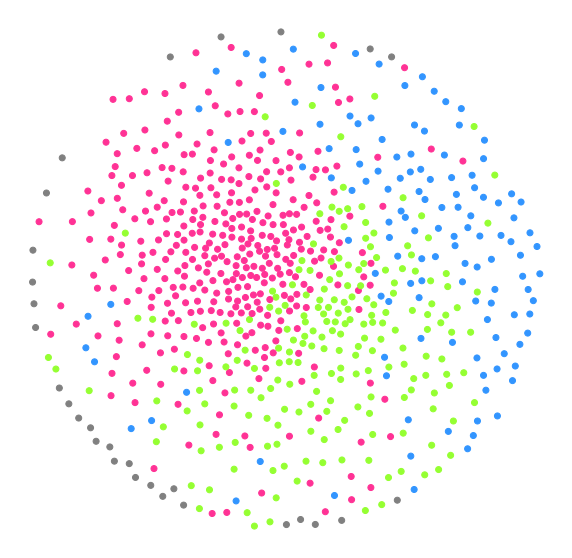

Graph 4.5 - Elapsed time: 4836.79s
Number of nodes: 879 - Non-zero weight percentage: 9.91%
Iteration 1000/1000 - Elapsed time: 304.40s - Force: 32131 - Speed: 0.20000
Complete! - Elapsed time: 304.40s


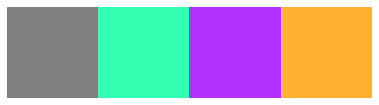

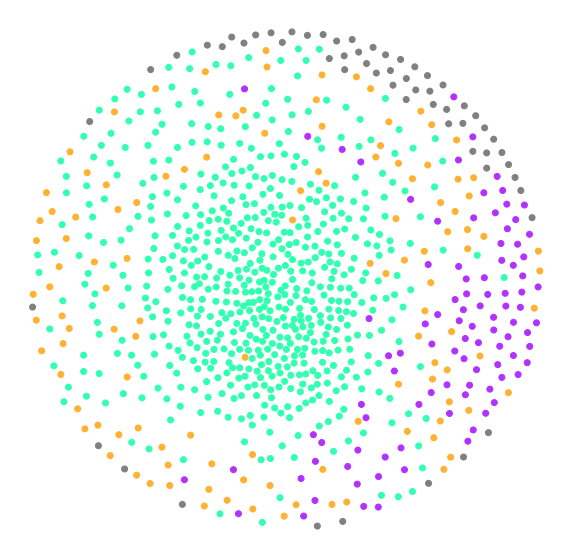

Graph 4.6 - Elapsed time: 5149.95s
Number of nodes: 605 - Non-zero weight percentage: 5.57%
Iteration 1000/1000 - Elapsed time: 87.38s - Force: 69730 - Speed: 0.20000
Complete! - Elapsed time: 87.38s


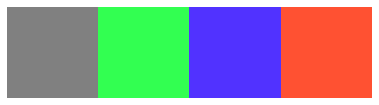

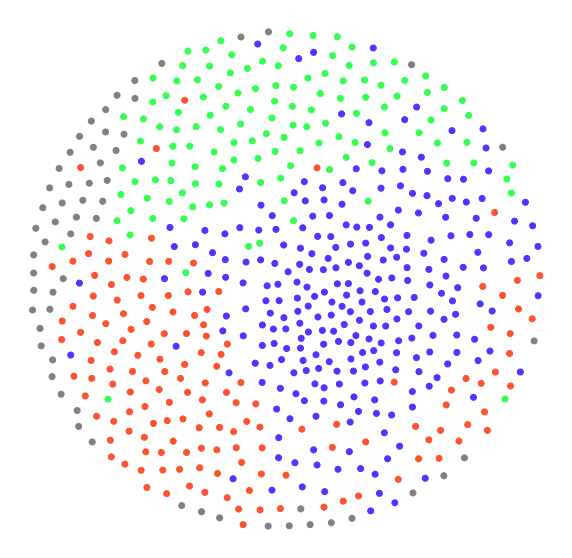

Graph 4.7 - Elapsed time: 5239.83s
Number of nodes: 595 - Non-zero weight percentage: 18.12%
Iteration 1000/1000 - Elapsed time: 226.27s - Force: 7424 - Speed: 0.200000
Complete! - Elapsed time: 226.27s


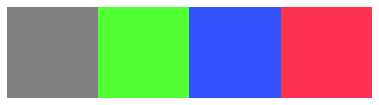

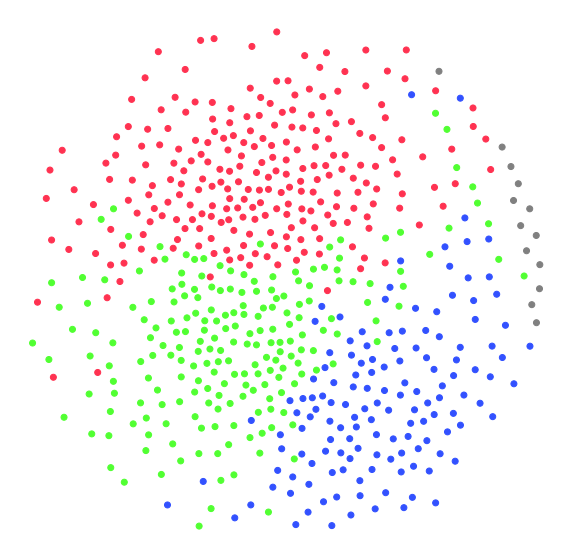

Graph 5.0 - Elapsed time: 5469.44s
Number of nodes: 827 - Non-zero weight percentage: 2.69%
Iteration 1000/1000 - Elapsed time: 98.48s - Force: 54465 - Speed: 0.20000
Complete! - Elapsed time: 98.48s


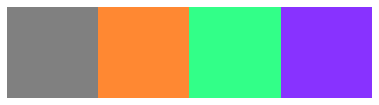

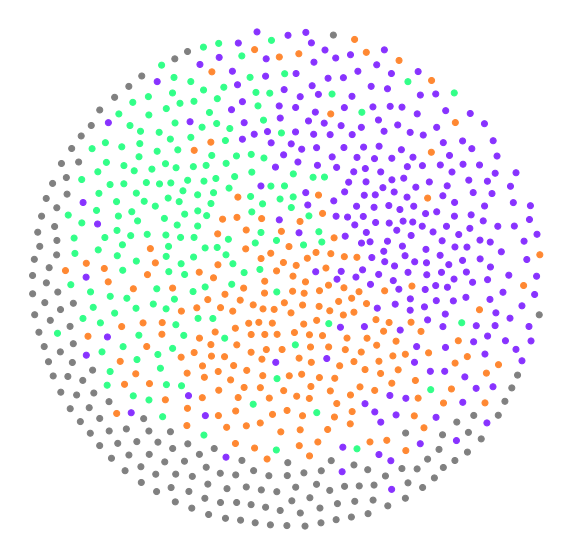

Graph 5.1 - Elapsed time: 5572.06s
Number of nodes: 839 - Non-zero weight percentage: 2.88%
Iteration 1000/1000 - Elapsed time: 106.84s - Force: 52453 - Speed: 0.2000
Complete! - Elapsed time: 106.84s


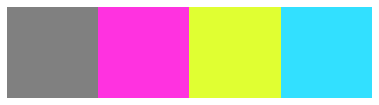

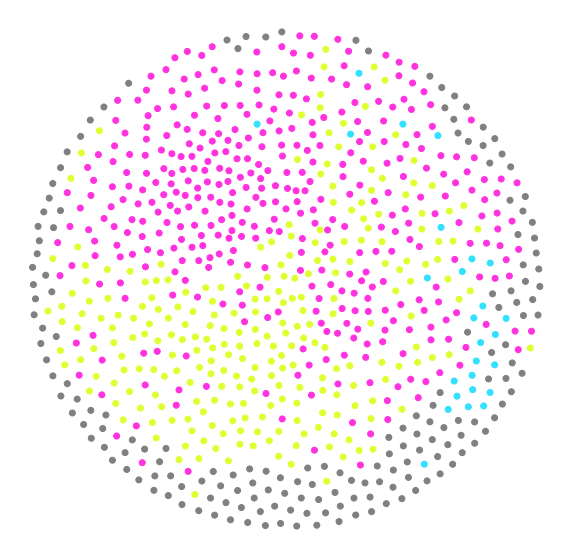

Graph 5.2 - Elapsed time: 5683.31s
Number of nodes: 561 - Non-zero weight percentage: 4.25%
Iteration 1000/1000 - Elapsed time: 61.75s - Force: 51816 - Speed: 0.20000
Complete! - Elapsed time: 61.75s


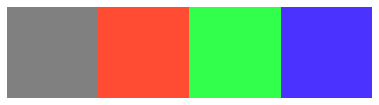

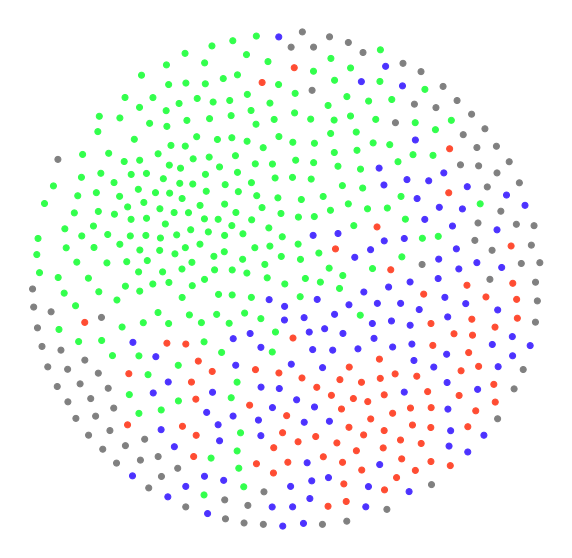

Graph 5.3 - Elapsed time: 5746.94s
Number of nodes: 519 - Non-zero weight percentage: 4.16%
Iteration 1000/1000 - Elapsed time: 52.44s - Force: 82025 - Speed: 0.20000
Complete! - Elapsed time: 52.44s


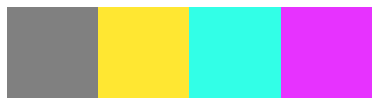

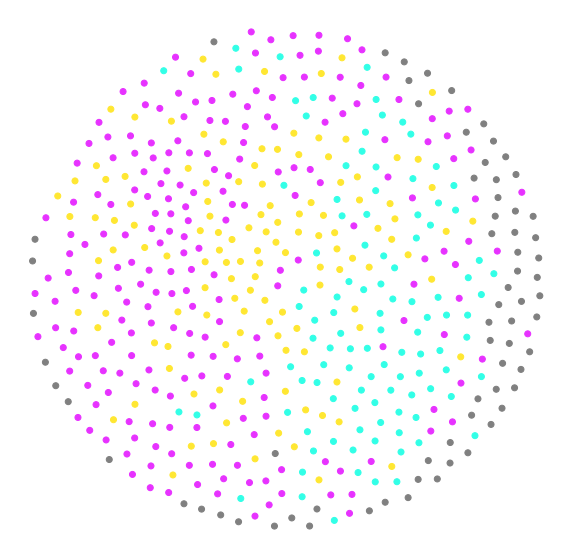

Graph 5.4 - Elapsed time: 5800.83s
Number of nodes: 383 - Non-zero weight percentage: 8.38%
Iteration 1000/1000 - Elapsed time: 50.61s - Force: 37849 - Speed: 0.20000
Complete! - Elapsed time: 50.61s


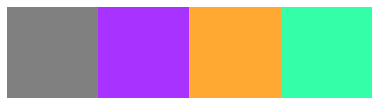

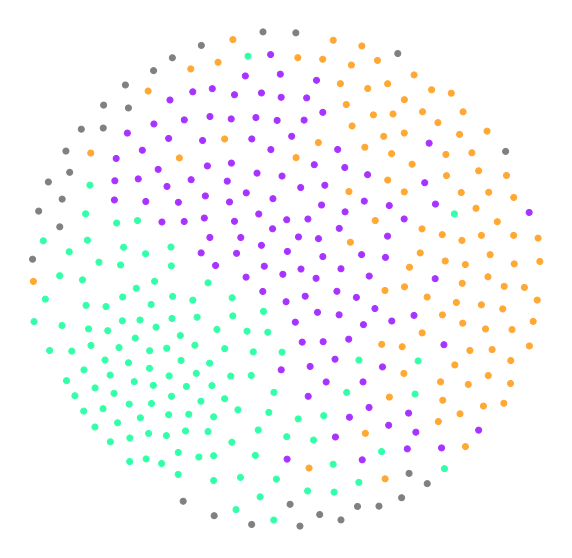

Graph 5.5 - Elapsed time: 5852.55s
Number of nodes: 595 - Non-zero weight percentage: 6.29%
Iteration 1000/1000 - Elapsed time: 91.59s - Force: 62426 - Speed: 0.20000
Complete! - Elapsed time: 91.59s


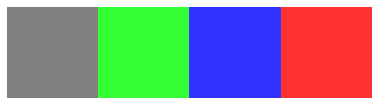

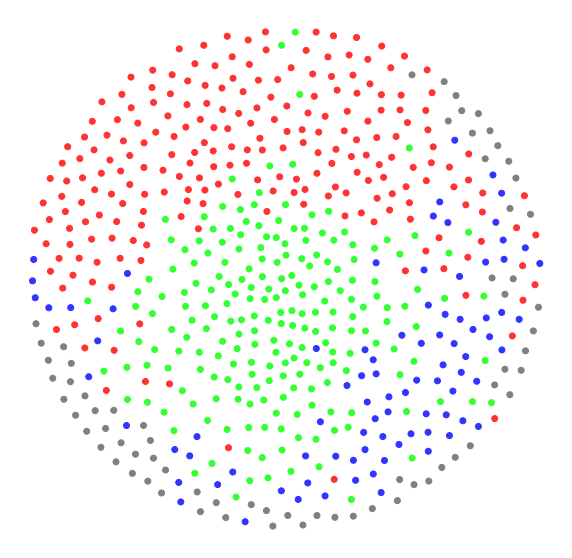

Graph 5.6 - Elapsed time: 5946.56s
Number of nodes: 490 - Non-zero weight percentage: 3.52%
Iteration 1000/1000 - Elapsed time: 42.35s - Force: 74409 - Speed: 0.20000
Complete! - Elapsed time: 42.35s


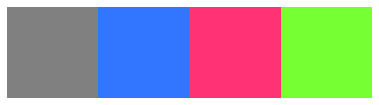

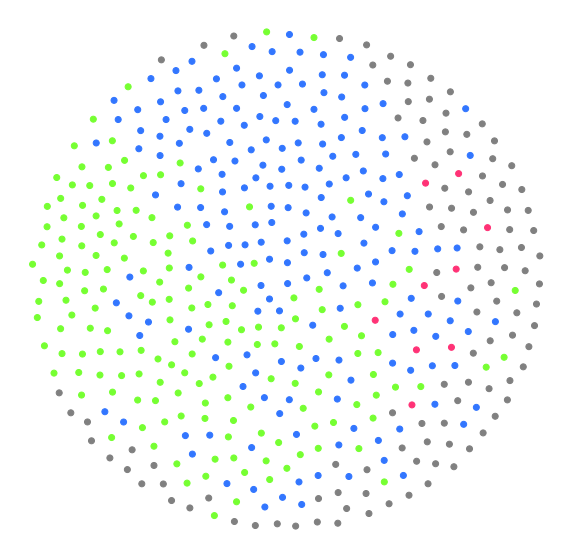

Graph 5.7 - Elapsed time: 5990.33s
Number of nodes: 401 - Non-zero weight percentage: 3.41%
Iteration 1000/1000 - Elapsed time: 28.39s - Force: 50365 - Speed: 0.20000
Complete! - Elapsed time: 28.39s


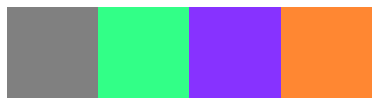

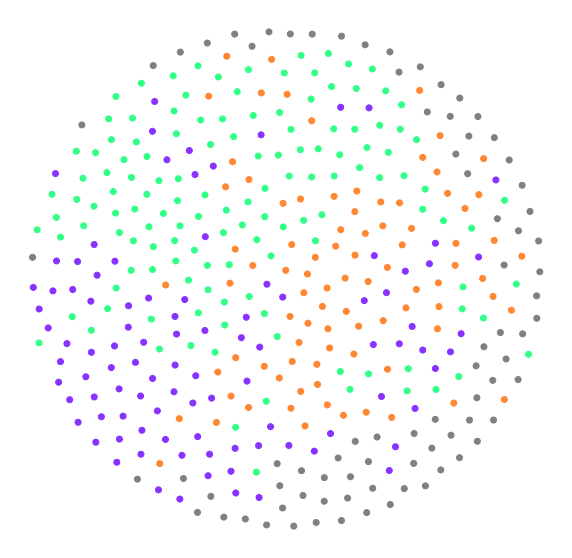

Graph 6.0 - Elapsed time: 6019.58s
Number of nodes: 436 - Non-zero weight percentage: 1.00%
Iteration 1000/1000 - Elapsed time: 18.61s - Force: 56608 - Speed: 0.2000
Complete! - Elapsed time: 18.61s


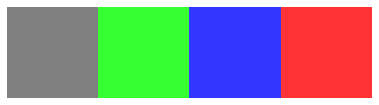

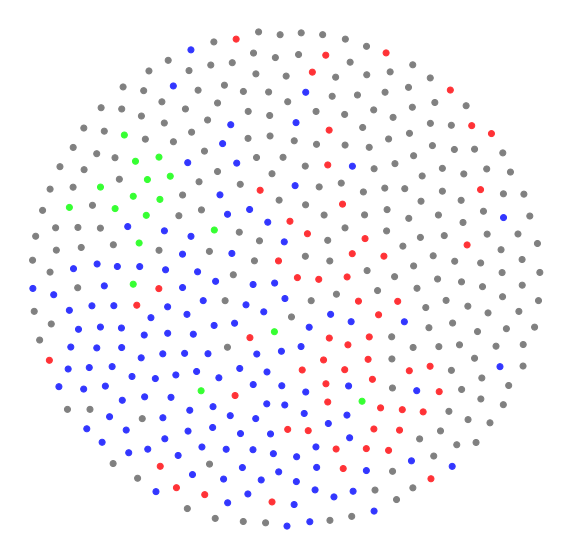

Graph 6.1 - Elapsed time: 6038.94s
Number of nodes: 260 - Non-zero weight percentage: 2.96%
Iteration 1000/1000 - Elapsed time: 10.44s - Force: 29628 - Speed: 0.2000
Complete! - Elapsed time: 10.44s


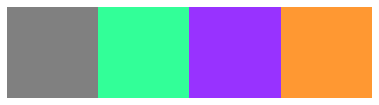

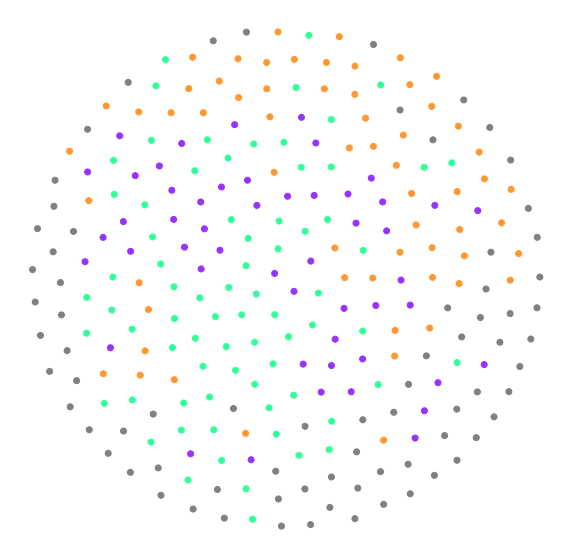

Graph 6.2 - Elapsed time: 6049.88s
Number of nodes: 249 - Non-zero weight percentage: 3.27%
Iteration 1000/1000 - Elapsed time: 10.23s - Force: 44379 - Speed: 0.2000
Complete! - Elapsed time: 10.23s


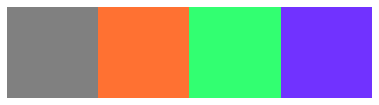

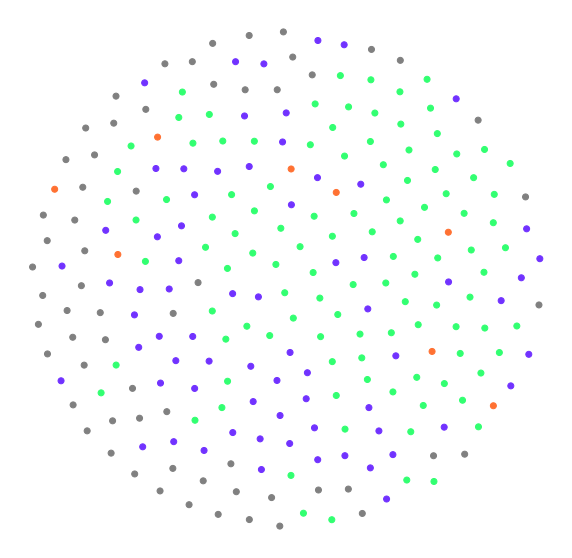

Graph 6.3 - Elapsed time: 6060.51s
Number of nodes: 262 - Non-zero weight percentage: 1.68%
Iteration 1000/1000 - Elapsed time: 7.83s - Force: 40417 - Speed: 0.20000
Complete! - Elapsed time: 7.83s


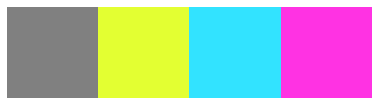

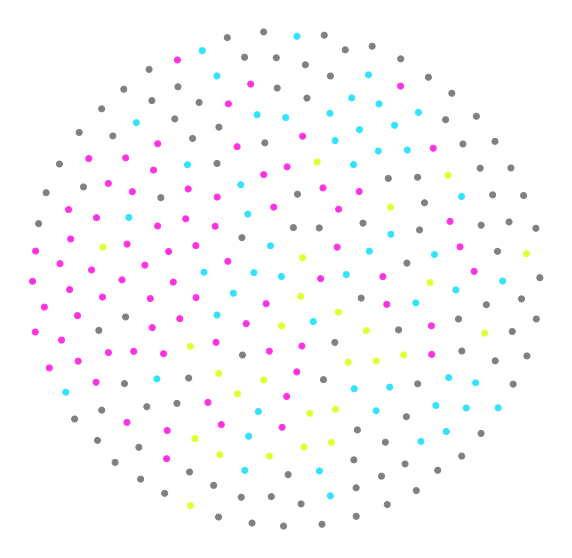

Graph 6.4 - Elapsed time: 6068.71s
Number of nodes: 296 - Non-zero weight percentage: 5.52%
Iteration 1000/1000 - Elapsed time: 24.47s - Force: 46625 - Speed: 0.2000
Complete! - Elapsed time: 24.47s


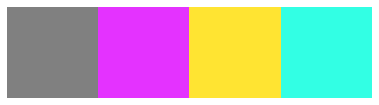

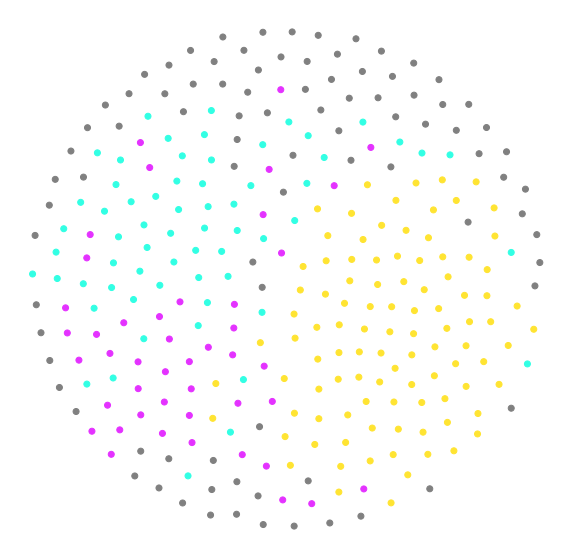

Graph 6.5 - Elapsed time: 6093.85s
Number of nodes: 238 - Non-zero weight percentage: 7.68%
Iteration 1000/1000 - Elapsed time: 17.77s - Force: 30400 - Speed: 0.2000
Complete! - Elapsed time: 17.77s


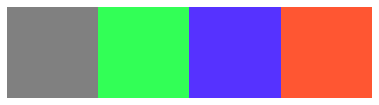

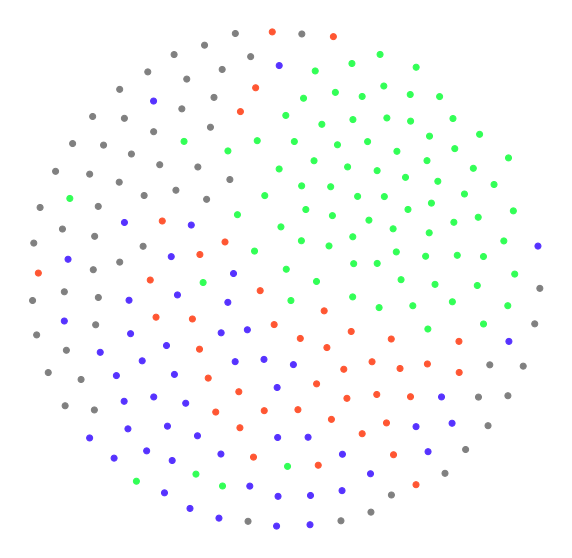

Graph 6.6 - Elapsed time: 6112.16s
Number of nodes: 140 - Non-zero weight percentage: 6.77%
Iteration 1000/1000 - Elapsed time: 6.29s - Force: 10834 - Speed: 0.20000
Complete! - Elapsed time: 6.29s


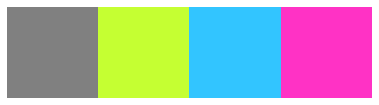

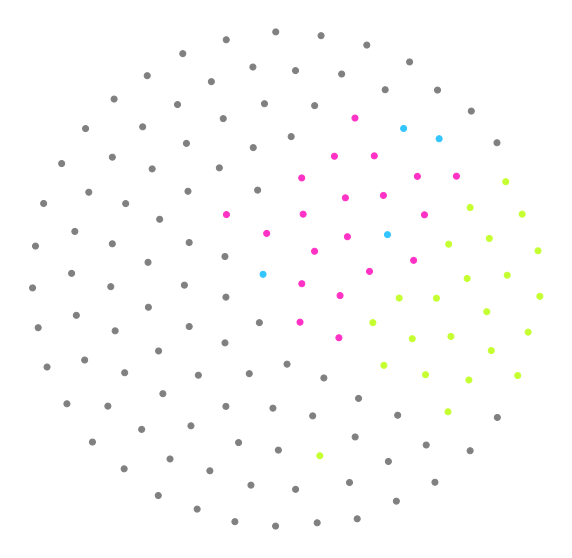

Graph 6.7 - Elapsed time: 6118.76s
Number of nodes: 228 - Non-zero weight percentage: 2.35%
Iteration 1000/1000 - Elapsed time: 7.34s - Force: 33049 - Speed: 0.20000
Complete! - Elapsed time: 7.34s


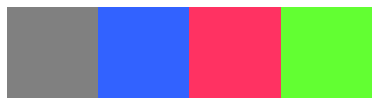

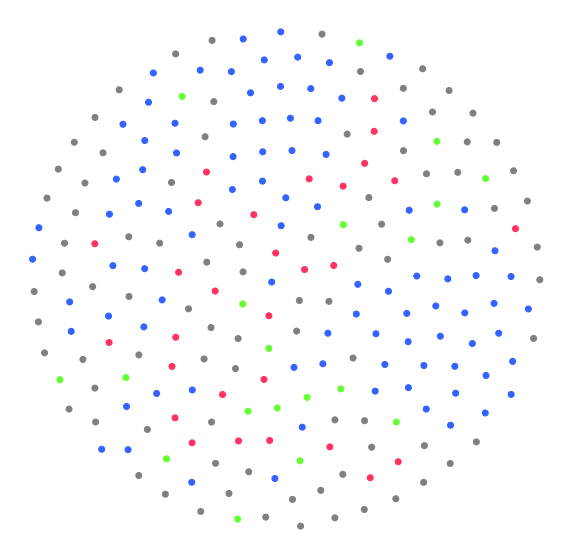

Graph 7.0 - Elapsed time: 6126.43s
Number of nodes: 819 - Non-zero weight percentage: 2.57%
Iteration 1000/1000 - Elapsed time: 90.98s - Force: 56337 - Speed: 0.20000
Complete! - Elapsed time: 90.98s


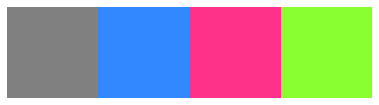

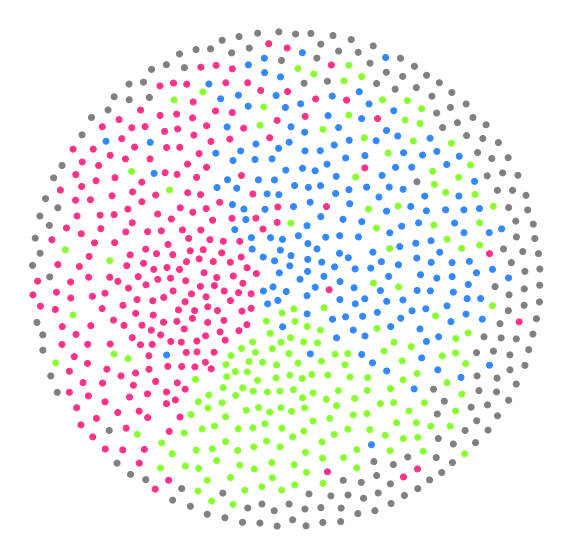

Graph 7.1 - Elapsed time: 6221.03s
Number of nodes: 1205 - Non-zero weight percentage: 1.96%
Iteration 1000/1000 - Elapsed time: 169.69s - Force: 79038 - Speed: 0.2000
Complete! - Elapsed time: 169.69s


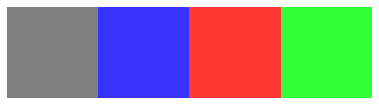

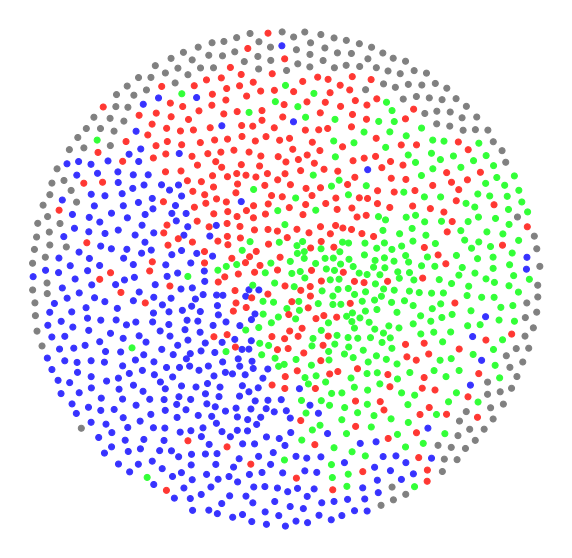

Graph 7.2 - Elapsed time: 6397.23s
Number of nodes: 826 - Non-zero weight percentage: 5.72%
Iteration 1000/1000 - Elapsed time: 166.82s - Force: 21096 - Speed: 0.20000
Complete! - Elapsed time: 166.82s


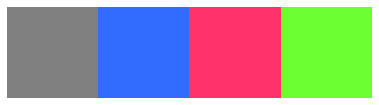

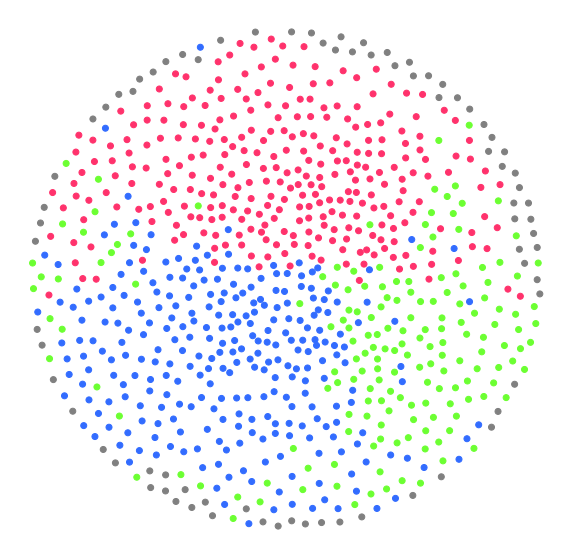

Graph 7.3 - Elapsed time: 6568.96s
Number of nodes: 1100 - Non-zero weight percentage: 2.56%
Iteration 1000/1000 - Elapsed time: 172.96s - Force: 73933 - Speed: 0.2000
Complete! - Elapsed time: 172.96s


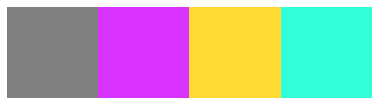

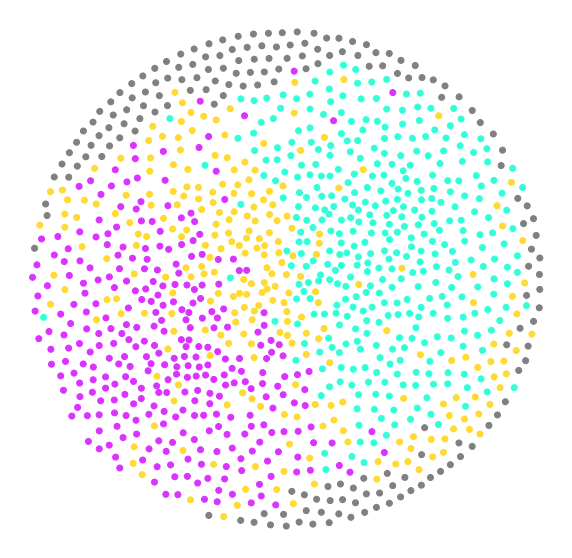

Graph 7.4 - Elapsed time: 6749.40s
Number of nodes: 792 - Non-zero weight percentage: 4.29%
Iteration 1000/1000 - Elapsed time: 127.69s - Force: 40637 - Speed: 0.2000
Complete! - Elapsed time: 127.69s


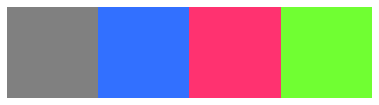

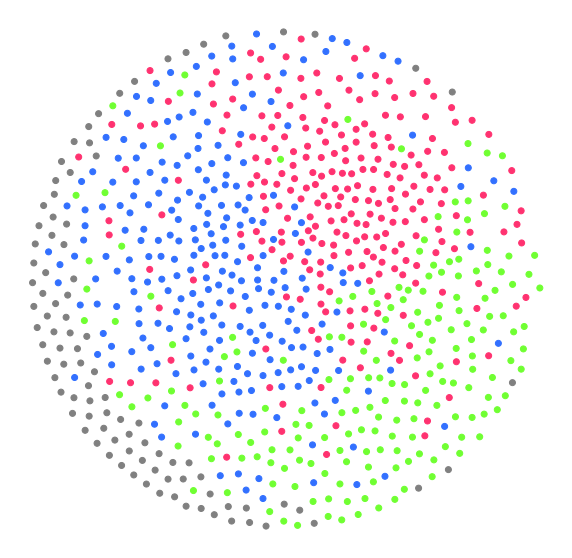

Graph 7.5 - Elapsed time: 6881.29s
Number of nodes: 893 - Non-zero weight percentage: 20.46%
Iteration 1000/1000 - Elapsed time: 567.69s - Force: 70337 - Speed: 0.200000
Complete! - Elapsed time: 567.69s


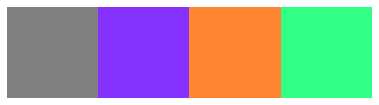

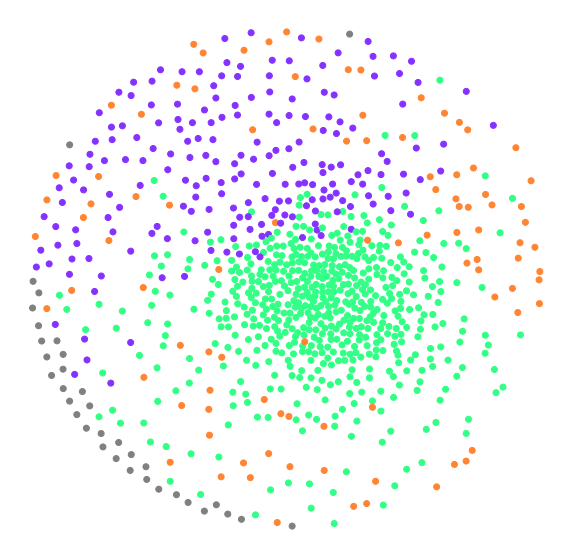

Graph 7.6 - Elapsed time: 7459.61s
Number of nodes: 1225 - Non-zero weight percentage: 4.26%
Iteration 1000/1000 - Elapsed time: 286.03s - Force: 52139 - Speed: 0.20000
Complete! - Elapsed time: 286.03s


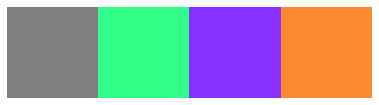

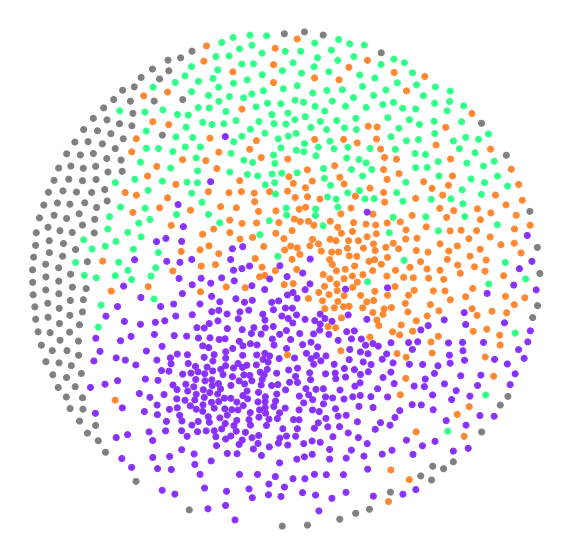

Graph 7.7 - Elapsed time: 7757.70s
Number of nodes: 809 - Non-zero weight percentage: 3.91%
Iteration 1000/1000 - Elapsed time: 126.10s - Force: 43706 - Speed: 0.2000
Complete! - Elapsed time: 126.10s


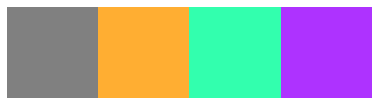

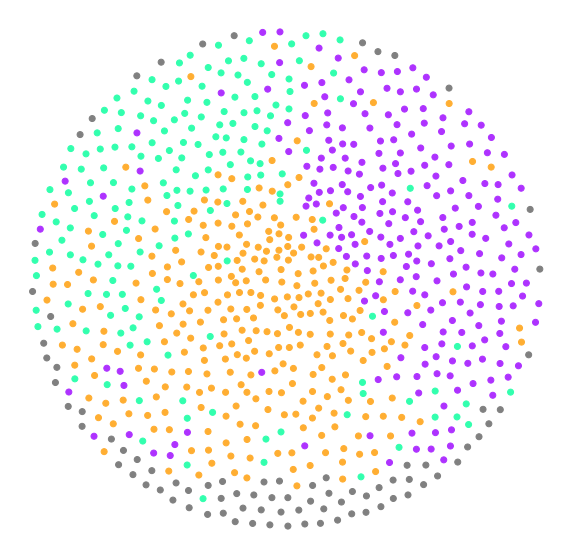

In [13]:
plot = True
plot_palette = True
start = time.time()
n_clusters = 3

for t in range(n_topics):
    for s in range(n_subtopics):
        elapsed_time = time.time() - start
        print("Graph " + repr(t) + "." + repr(s) + " - Elapsed time: " + "{0:0.2f}".format(elapsed_time) + "s")
        # Get the subtopic data
        embeddings = list(embeddings_splits[t][s])
        abstracts = abstracts_splits[t][s]
        titles = titles_splits[t][s]
        df_meta = df_meta_splits[t][s]
        
        # Construct the graph
        epsilon = 0.78
        adjacency = compute_adjacency(embeddings, epsilon)
        G = nx.from_numpy_array(adjacency)
        print("Number of nodes: " + repr(len(G.nodes)) + " - Non-zero weight percentage: " + '{0:.2f}'.format(adjacency[adjacency!=0].size * 100 / adjacency.size) + '%')
        
        # Label
        index_to_title = {}
        title_to_index = {}
        for i in list(G.nodes):
            index_to_title.update({i: titles[i]})
            title_to_index.update({titles[i]: i})
        G = nx.relabel.relabel_nodes(G, index_to_title)
        
        # Select main CC
        subgraphs = connected_components(G)
        G = subgraphs[0]  # Keep only the main connected component
        
        # Cluster
        clusters = compute_clusters_fluid(G, n_clusters=n_clusters, dtype='title')  # Works quite well with high epsilon (.85) and only keeping main connected component
        sum = 0
        for cluster in clusters:
            sum += len(cluster)
        title_to_cluster = {}
        i = 0
        for cluster in clusters:
            for title in cluster:
                if type(title) != str:
                    print("Error: title is not a string => " + repr(title))
                title_to_cluster.update({title: i})
            i += 1
        nx.set_node_attributes(G, title_to_cluster, "cluster")
        
        # Reconstruct full graph with all components
        for subgraph in subgraphs[1:]:
            G = nx.compose(G, subgraph)
            
        # Spacialize
        G = nx.relabel_nodes(G, title_to_index)
        layout = fruchterman(G, gravity=20., speed_init=200, iterations=1000)
        G = nx.relabel_nodes(G, index_to_title)
        
        # Compute color palette
        shift = random.uniform(0, 1)
        cluster_to_color = compute_palette(s=0.8, n_clusters=n_clusters, shift=shift, plot=plot_palette)
        
        # Write JSON
        json_G = json_graph.node_link_data(G, {'link': 'edges', 'name': 'label'})
        nodes = json_G['nodes']
        edges = json_G['edges']
        id_to_index = {}
        i = 0
        for node in nodes:
            cluster = node.get('cluster', -1)
            node['x'] = str(layout[node['label']][0])
            node['y'] = str(layout[node['label']][1])
            node['id'] = str(title_to_index[node['label']])  # Note: this ID does not correspond to the ID given by gephi but it doesnt matter
            node['attributes'] = {'cluster': str(cluster)}
            if cluster != -1:
                node.pop('cluster')
            node['color'] = cluster_to_color[cluster]
            node['size'] = 10.0
            id_to_index.update({node['id']: i})
            i += 1
        i = 0
        for edge in edges:
            edge['source'] = str(title_to_index[edge['source']])
            edge['target'] = str(title_to_index[edge['target']])
            edge['id'] = str(i)  # Note: this ID does not correspond to the ID given by gephi but it doesnt matter
            edge['attributes'] = {}
            source_node = nodes[id_to_index[edge['source']]]
            target_node = nodes[id_to_index[edge['target']]]
            r, g, b = merge_colors(source_node['color'], target_node['color'])
            edge['color'] = rgb_string(r, g, b)
            edge['size'] = edge.pop('weight')
            i += 1
            
        # Save JSON
        data = {'nodes': nodes, 'edges': edges}
        JSON_PATH = 'data/json/data_' + repr(t) + '_' + repr(s) + '.json'
        with open(JSON_PATH, 'w') as outfile:
            json.dump(data, outfile)
        
        # Plot
        if plot:
            colors = np.zeros((len(nodes), 3), dtype=np.float32)
            x = np.zeros((len(nodes),))
            y = np.zeros((len(nodes),))
            i = 0
            for node in nodes:
                r, g, b = rgb(node['color'])
                colors[i] = (r/255., g/255., b/255.)
                x[i] = node['x']
                y[i] = node['y']
                i += 1

            plt.figure(figsize=(10,10))
            plt.scatter(x, y, c=colors)
            plt.axis('off')
            plt.show()

The end.